# 2D Bicopter (Quadcopter)

We consider the self-righting quadrotor problem, see also: [Stanford AA203 HW](https://stanfordasl.github.io/aa203_sp2021/pdfs/homework/AA203_HW3.pdf)

We only consider vertical obstacles (floor and ceiling) and hence consider the reduced state for obstacle avoidance, whereas we consider the extended state for reaching a target


Extended state: $\mathbf{x} = [x, v_x, y, v_y, \phi, \omega]^T$
Reduced state: $\mathbf{x} = [y, v_y, \phi, \omega]^T$

Extended Dynamics:
$$\dot{x} = \begin{bmatrix}x_2 \\ \frac{ - C_D^v x_2}{m} \\ x_4 \\ \frac{ - C_D^v x_4}{m} - g\\ x_6 \\ \frac{- C_D^\phi x_6}{I{yy}}\end{bmatrix} + \begin{bmatrix}0 & 0 \\ \frac{-\sin(x_5)}{m} & \frac{-\sin(x_5)}{m} \\0 & 0 \\ \frac{\cos(x_5)}{m} & \frac{\cos(x_5)}{m} \\ 0 & 0 \\ -\frac{l}{I_{yy}} & \frac{l}{I_{yy}}\end{bmatrix}\underbrace{\begin{bmatrix}T_1 \\ T_2\end{bmatrix}}_{u}$$


Reduced Dynamics: 
$$\dot{x} = \begin{bmatrix}x_2 \\ \frac{ - C_D^v x_2}{m} - g \\ x_4 \\ \frac{- C_D^\phi x_4}{I{yy}}\end{bmatrix} + \begin{bmatrix}0 & 0 \\ \frac{\cos(x_3)}{m} & \frac{\cos(x_3)}{m} \\ 0 & 0 \\ -\frac{l}{I_{yy}} & \frac{l}{I_{yy}}\end{bmatrix}\underbrace{\begin{bmatrix}T_1 \\ T_2\end{bmatrix}}_{u}

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys; sys.version

In [177]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF, utils
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [ ]:
Cd_v = 0.25  # Drag coefficient
g = 9.81  # kg m / s^2
Cd_phi = 0.02255  # Drag coefficient
mass = 2.5  # kg
length = 1.0  # m
Iyy = 1.0  # kg m^2
dt = 0.01  # s

umax = 0.75 * mass * g * np.ones(2)
umin = np.zeros_like(umax)

### Dynamics

In [4]:
class QuadVerticalDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 4
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([
            state[1], 
            -state[1] * self.Cd_v / self.mass - self.g, 
            state[3], 
            -state[3] * self.Cd_phi / self.Iyy
            ])
    
    def control_matrix(self, state, time=0.0):
        return jnp.array([
            [0, 0], 
            [jnp.cos(state[2]) / self.mass, jnp.cos(state[2]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

    

In [ ]:
class QuadPlanarDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 6
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return np.array([
            state[1], 
            - state[1] * self.Cd_v / self.mass,
            state[3],
            - state[3] * self.Cd_v / self.mass - self.g,
            state[5], 
            -state[5] * self.Cd_phi / self.Iyy
            ])
    
    def state_jacobian(self, state, control, time=0.): # TODO: Should this include state[5]?
        return np.array([
            [0., 1., 0., 0., 0., 0.],
            [0., -self.Cd_v / self.mass, 0., 0., -(control[0] + control[1]) * np.cos(state[4]) / self.mass, 0.],
            [0., 0., 0., 1., 0., 0.],
            [0., 0., 0., -self.Cd_v / self.mass, (-control[0] + control[1]) * np.sin(state[4]) / self.mass, 0.],
            [0., 0., 0., 0., 0., 1.],
            [0., 0., 0., 0., 0., -self.Cd_phi / self.Iyy]
        ])
    def control_matrix(self, state, time=0.0):
        return np.array([
            [0, 0],
            [-np.sin(state[4]) / self.mass, -np.sin(state[4]) / self.mass],
            [0, 0], 
            [np.cos(state[4]) / self.mass, np.cos(state[4]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

In [5]:
params = {"Cd_v": Cd_v, "g": g, "Cd_phi": Cd_phi, "mass": mass, 
          "length": length, "Iyy": Iyy, "dt": dt}

dyn = QuadVerticalDynamics(params)
extended_dyn = QuadPlanarDynamics(params)

### Environment:
Safe set is as follows: 
$$\mathcal{E} = [1, 9] \times [-6, 6] \times [-\infty, \infty] \times [-8,8]$$

In [7]:
def safe_set(state):
    """A real-valud function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    return jnp.min(jnp.array([state[0] - 1, 9 - state[0], state[1] + 6, 6 - state[1], state[3] + 8, 8 - state[3]]))


### Initial Control Barrier Function

In [ ]:
class QuadVerticalCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.scaling = params["scaling"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return 10 - self.scaling[0] * (5 - state[0]) ** 2 - self.scaling[1] * (state[1]) ** 2 - self.scaling[2] * (state[2]) ** 2 - self.scaling[3] * (state[3]) ** 2

    def vf_dt_partial(self, state, time=0.0):
        return 0.0
    
    def _grad_vf(self, state, time=0.0):
        return self.scaling * np.array([2 * (5 - state[0]), - 2 * state[1], - 2 * state[2], - 2 * state[3]])

In [ ]:
cbf_params = dict()
cbf_params["scaling"] = np.array([0.75, 0.5, 2., 0.5])
quad_cbf = QuadVerticalCBF(dyn, cbf_params)

Two options: We learn a value function that indicates backup set (in a small region of the state space maybe around the hovering) and an unsafe region (outside of the operating range) OR we define a CBF ourselves with a bit of imagination

## Current implementation: Self-defined approximately correct value function

In [8]:
class QuadVerticalCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.scaling = params["scaling"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return 10 - self.scaling[0] * (5 - state[0]) ** 2 - self.scaling[1] * (state[1]) ** 2 - self.scaling[2] * (state[2]) ** 2 - self.scaling[3] * (state[3]) ** 2

    def vf_dt_partial(self, state, time=0.0):
        return 0.0
    
    def _grad_vf(self, state, time=0.0):
        return self.scaling * np.array([2 * (5 - state[0]), - 2 * state[1], - 2 * state[2], - 2 * state[3]])

In [9]:
cbf_params = dict()
cbf_params["scaling"] = np.array([0.75, 0.5, 2., 0.5])
quad_cbf = QuadVerticalCBF(dyn, cbf_params)

## Classical HJ solution

In [10]:
dyn_hjr = dynamics_hjr.HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([0., -8., -jnp.pi, -10.]), hi=jnp.array([10., 8., jnp.pi, 10.]))
grid_resolution = (25, 25, 30, 25)  # can/should be increased if running on GPU, or if extra patient

In [11]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [12]:
safe_values = hj.utils.multivmap(safe_set, jnp.arange(4))(grid.states)

In [13]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(safe_values))

In [14]:
# init_values = safe_values
# initial_time = 0.
# final_time = -5.
# times = jnp.linspace(initial_time, final_time, 101)
# target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)
# np.save("quad_2d/target_values_hjr.npy", target_values_hjr)
target_values_hjr = np.load("quad_2d/target_values_hjr.npy")

In [15]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
        
    cont = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], value_function[i][:,12,:,12], levels=[0], colors='g')

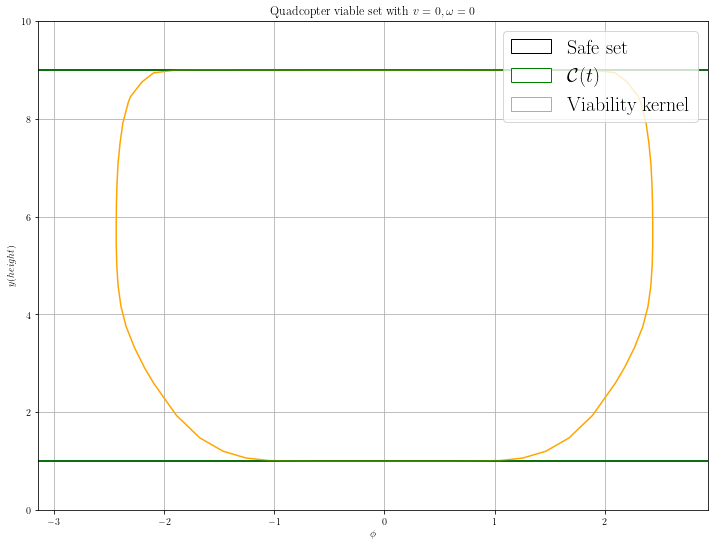

In [16]:
value_function = target_values_hjr
filename="quad_cbf.mp4"
proxy = [] 

fig, ax = plt.subplots(figsize=(12, 9))

cs = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], safe_values[:,12,:,12], levels=[0], colors='k')
proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') for pc in cs.collections]

cont = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], value_function[0][:,12,:,12], levels=[0], colors='g')
proxy += [plt.Rectangle((0,0),1,1,ec = 'g', fc='white')
        for pc in cont.collections]
cs = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], value_function[-1][:,12,:,12], levels=[0], colors='orange')
proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$\\phi$")
ax.set_ylabel("$y (height)$")
ax.set_title("Quadcopter viable set with $v=0, \omega = 0$")
ax.legend(proxy, ["Safe set", "$\mathcal{C}(t)$", "Viability kernel"], prop={'size': 20})

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0], interval=50)
# animation.save(filename, writer='ffmpeg', fps=30)

# CBF HJR


In [180]:
quad_tabular_cbf = cbf_hjr.TabularControlAffineCBF(dyn, grid=grid)

In [18]:
quad_tabular_cbf.tabularize_cbf(quad_cbf)

100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


In [19]:
# init_values = quad_tabular_cbf.vf_table
# initial_time = 0.
# final_time = -5.
# times = jnp.linspace(initial_time, final_time, 101)
# target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)

In [20]:
# fig, ax = plt.subplots(figsize=(10, 10))
# idx1 = 10
# idx2 = 10

# cont = ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], quad_tabular_cbf.vf_table[:,idx1,:,idx2], levels=[0], colors='g')
# ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], safe_values[:,idx1,:,idx2], levels=[0], colors='r')
# ax.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], target_values[-1][:,idx1,:,idx2], levels=[0], colors='b')

In [21]:
# quad_tabular_cbf.vf_table = np.array(target_values[-1])

## Online implementation

We consider the setting of having a linearized LQR nominal controller that attempts to stabilize us at a given point in the state space. Specifically, we consider a problem where we are "thrown" into the air by a user and we wish to stabilize the drone at a certain height (and possibly a non-constant angle)

Additionally we could include a 6D drone that include x positioning for the stabilizing behavior to get a more realistic scenario

AA203 text: Consider the goal of developing a self-righting quadrotor, i.e., a flying drone that you can chuck into the air at a range of poses/velocities which will autonomously regulate to level flight while obeying dynamics/controls/operational-envelope constraints.

In [22]:
class QuadPlanarDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 6
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return np.array([
            state[1], 
            - state[1] * self.Cd_v / self.mass,
            state[3],
            - state[3] * self.Cd_v / self.mass - self.g,
            state[5], 
            -state[5] * self.Cd_phi / self.Iyy
            ])
    
    def state_jacobian(self, state, control, time=0.): # TODO: Should this include state[5]?
        return np.array([
            [0., 1., 0., 0., 0., 0.],
            [0., -self.Cd_v / self.mass, 0., 0., -(control[0] + control[1]) * np.cos(state[4]) / self.mass, 0.],
            [0., 0., 0., 1., 0., 0.],
            [0., 0., 0., -self.Cd_v / self.mass, (-control[0] + control[1]) * np.sin(state[4]) / self.mass, 0.],
            [0., 0., 0., 0., 0., 1.],
            [0., 0., 0., 0., 0., -self.Cd_phi / self.Iyy]
        ])
    def control_matrix(self, state, time=0.0):
        return np.array([
            [0, 0],
            [-np.sin(state[4]) / self.mass, -np.sin(state[4]) / self.mass],
            [0, 0], 
            [np.cos(state[4]) / self.mass, np.cos(state[4]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

In [112]:
x_target_1 = np.array([15, 0, 5, 0, 0, 0])
x_target_2 = np.array([15, 0, 0.5, 0, 0, 0])
x_target_3 = np.array([15, 0, 12, 0, 0, 0])


control_at_rest = np.ones(2) * dyn.mass * dyn.g / 2.

x_start_1 = np.array([0, 0, 0, 0, 0, 0])  # Infeasible start, see what happens
x_start_2 = np.array([0, -2, 3, 4, np.pi/4, 4])  # Feasible start
x_start_3 = np.array([0, 0, 5, 0, 0, 0])  # Feasible start (easy)


## Creating a handcrafted CBF based on Lyapunov equations

In [24]:
extended_dyn = QuadPlanarDynamics(params)

In [25]:
from scipy.linalg import solve_continuous_lyapunov, solve_continuous_are

In [26]:
A, B = extended_dyn.linearized_ct_dynamics(x_target_1, control_at_rest)

In [27]:
A_d, B_d = extended_dyn.linearized_dt_dynamics(x_target_1, control_at_rest)

In [28]:
K = utils.lqr(A_d, B_d, np.eye(6), np.eye(2))

In [29]:
A_cl = A - B @ K
assert (np.linalg.eig(A_cl)[0] < 0).all(), "System is not stable"

In [30]:
P = utils.continuous_lyap(A_cl, np.eye(6))

In [31]:
expert_cbf = lambda V, c, x_target: lambda x, t=0.: c - (x - x_target) @ V @ (x - x_target)

In [32]:
state_domain = hj.sets.Box(lo=jnp.array([-30, -8., 0., -8., -jnp.pi, -10.]), hi=jnp.array([30., 8., 10., 8., jnp.pi, 10.]))
grid_resolution = (5, 5, 25, 25, 30, 25)

In [33]:
extended_grid = grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=4)

In [34]:
operating_state = np.array([0, 0, 5., 0, 0, 0])  # In the center of the operating range
control_at_rest = extended_dyn.mass * extended_dyn.g / 2 * np.ones(2)

In [35]:
cbf_alt = expert_cbf(P, 5, x_target_1)
vals = hj.utils.multivmap(cbf_alt, jnp.arange(6))(extended_grid.states)

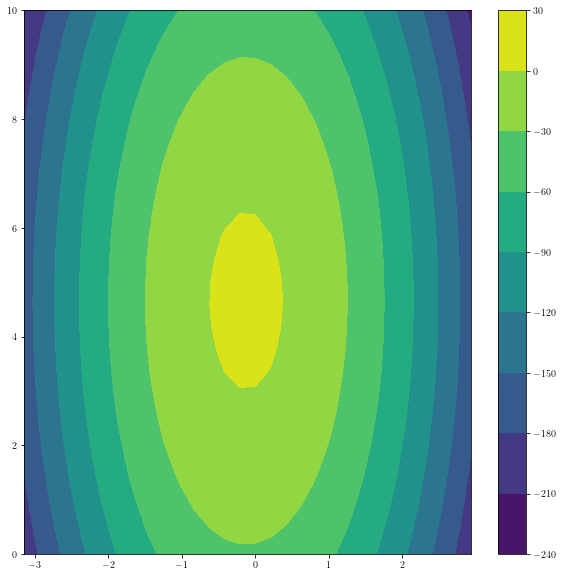

In [38]:

fig, ax = plt.subplots(figsize=(10,10))
c = ax.contourf(grid.coordinate_vectors[2], grid.coordinate_vectors[0], vals[3, 2, :, 13, :, 13])
fig.colorbar(c)

In [39]:
# quad_tabular_cbf_2 = cbf_hjr.TabularCBF(dyn, grid=grid)

In [40]:
# quad_tabular_cbf_2.vf_table = vals

In [41]:
nominal_control = lambda u_ref, x_ref, F: lambda x, t: np.clip(u_ref - F @ (x - x_ref), umin, umax)

In [42]:
nominal_control_2 = lambda u_ref, x_ref, F: lambda x, t: np.clip(u_ref - np.array([1, -1]) * (x[0] - x_ref[0]) - 10 * np.ones(2) * (x[2] - x_ref[2]), umin, umax)

In [43]:
from tqdm import tqdm

In [181]:
quad_tabular_cbf.vf_table = target_values_hjr[-1]

In [182]:
alpha = lambda x: 5 * x

In [272]:
x0 = np.array([0, 3, 2, -3, - np.pi/4, 1])
x_goal = np.array([15, 0, 1.5, 0, 0, 0])
nom_control = nominal_control(control_at_rest, x_goal, K)
quad_asif = asif.ControlAffineASIF(dyn, quad_tabular_cbf, alpha=alpha, nominal_policy=nom_control, umin=umin, umax=umax)

In [273]:
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
new_vf_vals = np.repeat(np.repeat(quad_tabular_cbf.vf_table[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)

In [274]:
states = [x0]
control = []
control_filt = []
control_filt_ws = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_ws = x0
states_filt_ws = [x0]
# vf_filt = [dubins_cbf.vf(x0, 0.)]
vf_filt_ws = [quad_tabular_cbf.vf(x0[2:], 0.)]
ts = np.arange(0, 10, .01)

x = x0
for i, t in enumerate(tqdm(ts)):  
    # if i % 5 == 0:
    input_nom = np.array(nom_control(x, t))

    x = np.array(extended_dyn.step(x, input_nom))
    x[4] = (x[4] + np.pi) % (2 * np.pi) - np.pi
    states.append(x)
    control.append(input_nom)


for i, t in enumerate(tqdm(ts)):  
    # if i % 5 == 0:
    if t >= 3.0:
        temp = 1
    input_nom = np.array(quad_asif(x_filt_ws[2:], nominal_control = nom_control(x_filt_ws,t), time=t)).flatten()
    x_filt_ws = np.array(extended_dyn.step(x_filt_ws, input_nom))
    x_filt_ws[4] = (x_filt_ws[4] + np.pi) % (2 * np.pi) - np.pi
    states_filt_ws.append(x_filt_ws)
    control_filt_ws.append(input_nom)
    vf_filt_ws.append(quad_tabular_cbf.vf(x_filt_ws[2:], t))



100%|██████████| 1000/1000 [02:07<00:00,  7.83it/s]


In [232]:
matplotlib.rcParams['lines.linewidth'] = 3

(0.0, 10.0)

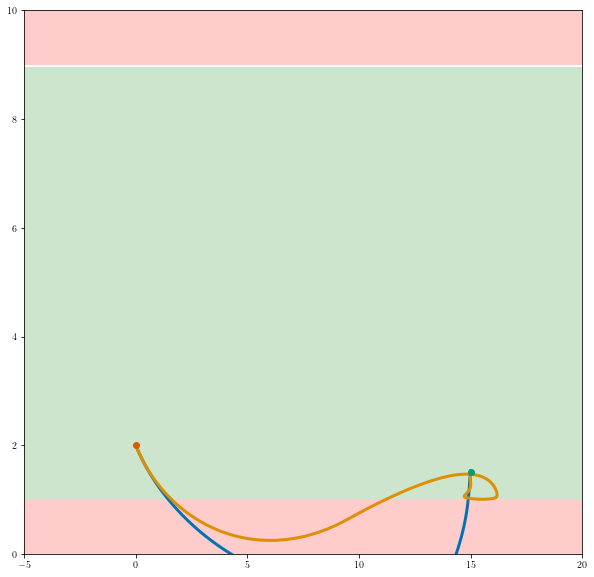

In [275]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_palette("colorblind")
ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vf_vals[:, 2, :, 13, 15, 13].T, levels=[0, 100], colors='green', alpha=.2)
ax.plot(np.array(states)[:, 0], np.array(states)[:, 2])
ax.plot(np.array(states_filt_ws)[:, 0], np.array(states_filt_ws)[:, 2])
ax.plot(x_goal[0], x_goal[2], 'o')
ax.plot(x0[0], x0[2], 'o')
ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], colors='r', alpha=.2)

ax.set_xlim([-5, 20])
ax.set_ylim([0,10])

(0.0, 9.99)

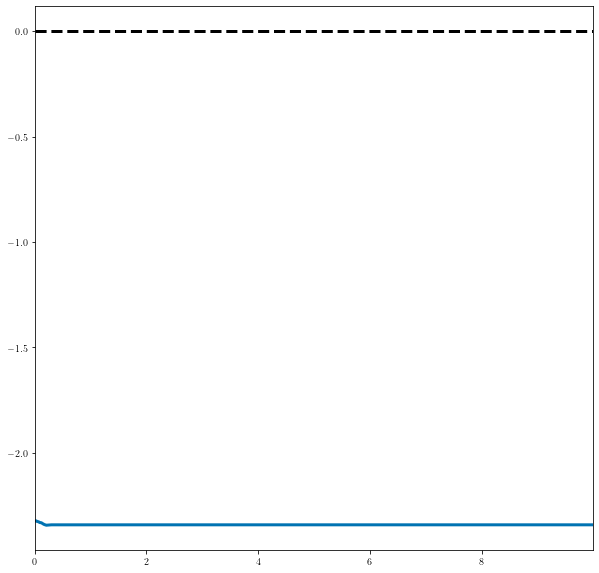

In [271]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ts, vf_filt_ws[1:])
ax.plot(ts, np.zeros_like(vf_filt_ws[1:]), '--k')
ax.set_xlim([ts[0], ts[-1]])

(0.0, 10.0)

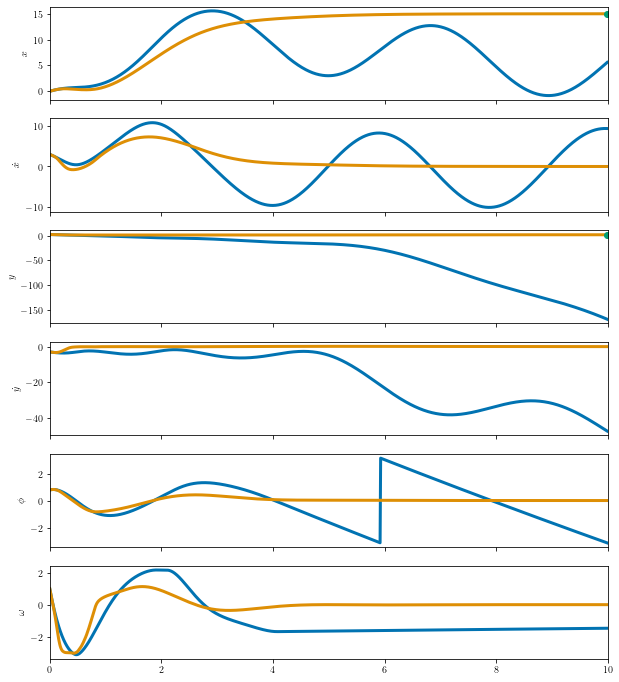

In [244]:
fig, ax = plt.subplots(6, 1, figsize=(10,12), sharex=True)
ax[0].plot(ts, np.array(states)[:-1, 0], label="$x$")
ax[0].plot(ts, np.array(states_filt_ws)[:-1, 0], label="$x_{filtered}$")
ax[0].plot(ts[-1], x_goal[0], 'o', label="$y_{target}$")
ax[1].plot(ts, np.array(states)[:-1, 1], label="$\dot x$")
ax[1].plot(ts, np.array(states_filt_ws)[:-1, 1], label="$\dot x_{filtered}$")
ax[2].plot(ts, np.array(states)[:-1, 2], label="$y$")
ax[2].plot(ts, np.array(states_filt_ws)[:-1, 2], label="$y_{filtered}$")
ax[2].plot(ts[-1], x_goal[2], 'o', label="$y_{target}$")
ax[3].plot(ts, np.array(states)[:-1, 3], label="$\dot y$")
ax[3].plot(ts, np.array(states_filt_ws)[:-1, 3], label="$\dot y_{filtered}$")
ax[4].plot(ts, np.array(states)[:-1, 4], label="$\phi$")
ax[4].plot(ts, np.array(states_filt_ws)[:-1, 4], label="$\phi_{filtered}$")
ax[5].plot(ts, np.array(states)[:-1, 5], label="$\omega$")
ax[5].plot(ts, np.array(states_filt_ws)[:-1, 5], label="$\omega_{filtered}$")
ax[0].set_ylabel('$x$')
ax[1].set_ylabel('$\dot x$')
ax[2].set_ylabel('$y$')
ax[3].set_ylabel('$\dot y$')
ax[4].set_ylabel('$\phi$')
ax[5].set_ylabel('$\omega$')
ax[5].set_xlim([0, 10])

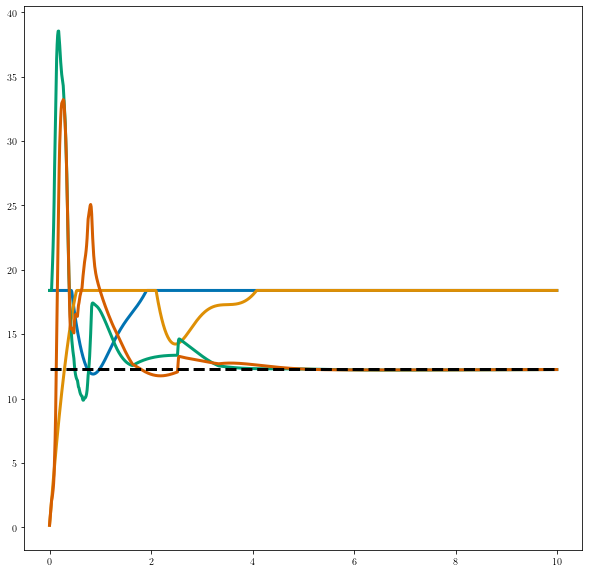

In [246]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ts, np.array(control)[:, 0], label="$u_1$")
ax.plot(ts, np.array(control)[:, 1], label="$u_2$")
ax.plot(ts, np.array(control_filt_ws)[:, 0], label="$u_1$")
ax.plot(ts, np.array(control_filt_ws)[:, 1], label="$u_2$")
ax.plot(ts, control_at_rest[0] * np.ones_like(ts), '--k')

In [109]:
from refine_cbfs.utils.visualize_vf import animate_planar_quad

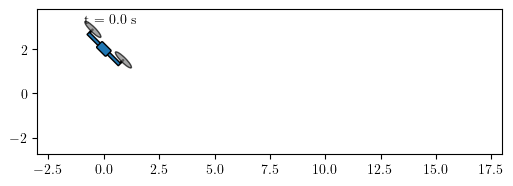

In [278]:
fig, ani = animate_planar_quad(ts, np.array(states)[:,0], np.array(states)[:,2], np.array(states)[:,4])

In [279]:
ani.save("quad_2d/invalid_lol.mp4", writer='ffmpeg', fps=30)

In [ ]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.animation as anim